In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.classify import NaiveBayesClassifier, DecisionTreeClassifier, SklearnClassifier, WekaClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import wordnet
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import os
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
% matplotlib inline

Aggregate bad words to list

In [2]:
folder = r'Data of bad words'
paths = os.listdir(folder)
list_of_bad_words = []
chars_to_remove = '\n\xa0'
for path in paths:
    curr_path = os.path.join(folder, path)
    with open(curr_path, 'r') as input_file:
        raw_list_of_words = input_file.readlines()
        list_of_bad_words.extend([x.strip(chars_to_remove)
                              for x in raw_list_of_words])
list_of_bad_words = list(set(list_of_bad_words))

Import database of labeld chats

In [3]:
file_path = r'data/formspring_data.csv'
raw_data = pd.read_csv(file_path, sep='\t')

In [4]:
for ind in range(1,4):
    col = 'severity'+str(ind)
    raw_data[col].loc[raw_data[col] == 'None'] = 0
    raw_data[col].loc[raw_data[col] == 'n/a0'] = 0
    raw_data[col].loc[raw_data[col] == 'n/a'] = 0
    raw_data[col].loc[raw_data[col] == 'o'] = 0
    raw_data[col].loc[raw_data[col] == '0`'] = 0
    raw_data[col].loc[raw_data[col] == '`0'] = 0
    raw_data[col].loc[raw_data[col] == 'N/a'] = 0

Parse database into dataframe

In [5]:
posts, bully_bool, bully_num = [], [], []
for ind, row in raw_data.iterrows():
    post = row['post'].lstrip('Q: ').replace('<br>A: ','')
    posts.append(post)
    severity = [int(row['severity1']), 
                int(row['severity2']), 
                int(row['severity3'])]
    bully_bool.append(severity.count(0) <= 1)
    if bully_bool[ind]:
        bully_num.append(sum(severity) 
                         / (3 - severity.count(0)))
    else:
        bully_num.append(0)

data = pd.DataFrame({'post': posts, 
                     'is_bully': bully_bool,
                     'bully_severity': bully_num})
data.to_csv('parsed_data.csv')

Explore bully comments

In [6]:
word_dict = {}
for ind, row in data.loc[data.loc[:, 'is_bully'] == True, 'post'].iteritems():
    for word in row.split():
        if word.lower() not in word_dict:
            word_dict[word.lower()] = 1
        else:
            word_dict[word.lower()] += 1
sorted(word_dict.items(), key=lambda x: x[1], reverse=True)

[('you', 714),
 ('i', 519),
 ('a', 419),
 ('and', 347),
 ('your', 329),
 ('to', 321),
 ('the', 266),
 ('me', 178),
 ('is', 159),
 ('u', 152),
 ('not', 151),
 ('my', 146),
 ('that', 146),
 ('of', 140),
 ('are', 133),
 ('it', 132),
 ('like', 127),
 ('do', 121),
 ('so', 121),
 ('have', 112),
 ('get', 107),
 ('im', 106),
 ('fake', 105),
 ('on', 103),
 ('know', 98),
 ('r', 98),
 ('who', 93),
 ('be', 93),
 ('dont', 93),
 ('for', 92),
 ('in', 91),
 ('bitch', 85),
 ('fuck', 83),
 ('with', 82),
 ('if', 82),
 ('ur', 81),
 ('just', 79),
 ('no', 79),
 ('what', 78),
 ('shit', 78),
 ('she', 78),
 ('fucking', 73),
 ('her', 70),
 ('how', 69),
 ('one', 69),
 ('think', 68),
 ('would', 67),
 ('but', 66),
 ('stop', 63),
 ('this', 62),
 ('ass', 61),
 ('up', 61),
 ('love', 61),
 ('was', 57),
 ('go', 57),
 ('all', 57),
 ('why', 56),
 ('about', 52),
 ('ugly', 50),
 ('out', 50),
 ('say', 50),
 ('people', 49),
 ('lol', 48),
 ('can', 48),
 ("don't", 45),
 ('off', 45),
 ('as', 43),
 ('at', 43),
 ('life', 42),
 ('

Data to train and test

In [7]:
X = data.loc[:, 'post']
y = data.loc[:, 'is_bully']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3)

In [8]:
def plot_roc_curve(y_true, prob):
    fpr, tpr, th = roc_curve(y_true, prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [38]:
from nltk.corpus import wordnet

class AntonymReplacer(object):
    def replace(self, word, pos=None):
        antonyms = set()
        for syn in wordnet.synsets(word, pos=pos):
            for lemma in syn.lemmas():
                for antonym in lemma.antonyms():
                    antonyms.add(antonym.name())
        if len(antonyms) == 1:
            return antonyms.pop()
        else:
            return None
    
    def replace_negations(self, sent):
        i, l = 0, len(sent)
        words = []
        while i < l:
            word = sent[i]
            if word == 'not' and i + 1 < l:
                ant = self.replace(sent[i + 1])
                if ant:
                    words.append(ant)
                    i += 2
                    continue
            words.append(word)
            i += 1
        return words

In [39]:
ant_replace = AntonymReplacer()

In [40]:
a = 'You are not stupid'
ant_replace.replace_negations(a.split(' '))

['You', 'are', 'not', 'stupid']

In [62]:
class HeuristicClassifier(object):
    def __init__(self, list_of_words):
        self.list_of_bad_words = list_of_words
        self.prob = []
        self.replacer = AntonymReplacer()
    
    def fit(self, X, y):
        sum_words = []
        for ind, row in enumerate(X):
            sentence = row.split(' ')
            sentence = self.replacer.replace_negations(sentence)
            sum_words.append(sum([(word1.lower() in self.list_of_bad_words) or
                                  (word2.lower() in self.list_of_bad_words)
                                  for word1, word2 in zip(sentence[:-1], sentence[1:])]))
            self.prob.append(sum_words[ind] / len(sentence))
        _, _, th = roc_curve(y, self.prob)
        self.thershold = th[-2]
        
    def predict(self, X):
        if isinstance(X, str) is True:
            X = [X]
        sum_words, prob_to_bully = [], []
        for ind, row in enumerate(X):
            sentence = row.split(' ')
            sentence = self.replacer.replace_negations(sentence)
            sum_words.append(sum([(word1.lower() in self.list_of_bad_words) or
                                  (word2.lower() in self.list_of_bad_words)
                                  for word1, word2 in zip(sentence[:-1], sentence[1:])]))
            prob_to_bully.append(sum_words[ind] / len(sentence))
            y_pred = [prob > self.thershold for prob in prob_to_bully]
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        print('log loss: %s' % log_loss(y, y_pred))
        print('accuracy: %s' % accuracy_score(y, y_pred))

log loss: 5.281863146609417
accuracy: 0.8470772442588727


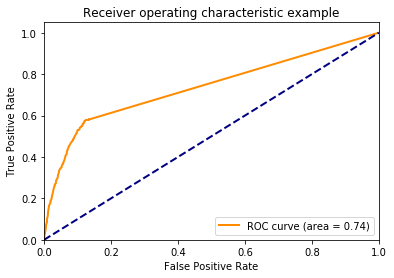

In [63]:
hc = HeuristicClassifier(list_of_bad_words)
hc.fit(X_train, y_train)
hc.score(X_test, y_test)
plot_roc_curve(y_train, hc.prob)

In [65]:
hc.predict('he said you are not stupid')

[True]

Pickle model

In [207]:
model_file_path = 'model.pickle'
with open(model_file_path, 'wb') as output_file:
    pickle.dump(hc, output_file)

Testing opening pickle

In [210]:
model_file_path = 'model.pickle'
with open(model_file_path, 'rb') as input_file:
    clf = pickle.load(input_file)
    
clf.predict('I will kill you')

[True]

Dill model

In [72]:
# import dill
# model_file_path = 'model.pickle'
# with open(model_file_path, 'wb') as output_file:
#     dill.dump(hc, output_file)

# Trying nltk sentiment analysis

In [85]:
docs = [(word_tokenize(post),
         'bully' if is_bully else 'not bully') for
         post, is_bully in zip(data['post'], data['is_bully'])]

In [133]:
bully_docs = [doc for doc in docs if doc[1] == 'bully']
not_bully_docs = [doc for doc in docs if doc[1] == 'not bully']

In [167]:
undersampled_docs = not_bully_docs[::10]
undersampled_docs += bully_docs

In [186]:
oversampled_docs = bully_docs * 14
oversampled_docs += not_bully_docs

In [187]:
train_docs, test_docs = train_test_split(undersampled_docs, train_size=0.8, test_size=0.2)
train_docs, val_docs = train_test_split(train_docs, train_size=0.82, test_size=0.18)

In [188]:
sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])

In [189]:
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [190]:
train_set = sentim_analyzer.apply_features(train_docs)
val_set = sentim_analyzer.apply_features(val_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [240]:
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, train_set)

Training classifier


In [242]:
for key, value in sorted(sentim_analyzer.evaluate(train_set).items()):
    print('{0}: {1}'.format(key, value))

Evaluating NaiveBayesClassifier results...
Accuracy: 0.9085365853658537
F-measure [bully]: 0.8841698841698841
F-measure [not bully]: 0.924433249370277
Precision [bully]: 0.9123505976095617
Precision [not bully]: 0.9061728395061729
Recall [bully]: 0.8576779026217228
Recall [not bully]: 0.9434447300771208


In [243]:
for key, value in sorted(sentim_analyzer.evaluate(val_set).items()):
    print('{0}: {1}'.format(key, value))

Evaluating NaiveBayesClassifier results...
Accuracy: 0.8090277777777778
F-measure [bully]: 0.7465437788018432
F-measure [not bully]: 0.8467966573816156
Precision [bully]: 0.7570093457943925
Precision [not bully]: 0.8397790055248618
Recall [bully]: 0.7363636363636363
Recall [not bully]: 0.8539325842696629


In [244]:
for key, value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key,  value))

Evaluating NaiveBayesClassifier results...
Accuracy: 0.8025
F-measure [bully]: 0.7459807073954983
F-measure [not bully]: 0.838445807770961
Precision [bully]: 0.7581699346405228
Precision [not bully]: 0.8299595141700404
Recall [bully]: 0.7341772151898734
Recall [not bully]: 0.8471074380165289


In [163]:
def preprocessing(text, analyzer):
    tokens = word_tokenize(text)
    marked_tokens = mark_negation(tokens)
    return marked_tokens

In [278]:
sentim_analyzer.classify(preprocessing("franch is such a pussy", sentim_analyzer))

'bully'

In [292]:
with open("data/livedemo-conversation-dirty.txt", 'r') as f:
    for line in f.readlines():
        sentence = line.split(':')[1]
        res = sentim_analyzer.classify(preprocessing(sentence, sentim_analyzer))
        print('(' + res + ') ' + line[:-1])

(not bully) Alex: Hi, guys! How are you doing?
(not bully) Tal: I'm fine, and you?
(bully) Franch: Cool, but Itai is being a big baby!
(bully) Tal: Yeah, he's such a turd!
(bully) Itai: Stop, guys, this is making me sad.
(not bully) Franch: Shut up, you wuss!
(bully) Alex: I will beat you after school!
(bully) Tal: Stop it guys, that's enough! Not fun anymore
